In [1]:
import csv
import pandas as pd
import numpy as np
import os
import torch
import datetime
from torch.utils.data import Dataset

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
! ls data

icu  measurements  preprocessed


In [3]:
PATH = "data/preprocessed"        

class MortalityDataset(Dataset):    
    def __init__(self):
        self.sequences = []
        self.labels = []
        
        sequences = []
        directory = os.fsencode(f"{PATH}")
        fs = os.listdir(directory)
        for idx, file in enumerate(fs):
            filename = os.fsdecode(file)
            if not filename.endswith(".csv"): 
                continue
                
            df = pd.read_csv(f"{PATH}/{filename}")
            y_true = df["y_true"][0]
            del df["y_true"]
            
            data = torch.from_numpy(df.values)
            self.sequences.append(data)
            self.labels.append(y_true)
            
            if idx % 500 == 0:
                print(f"loaded {idx+1} out of {len(fs)}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [4]:
m = MortalityDataset()
print(m[0])
print(m[1])

loaded 1 out of 20030
loaded 501 out of 20030
loaded 1001 out of 20030
loaded 1501 out of 20030
loaded 2001 out of 20030
loaded 2501 out of 20030
loaded 3001 out of 20030
loaded 3501 out of 20030
loaded 4001 out of 20030
loaded 4501 out of 20030
loaded 5001 out of 20030
loaded 5501 out of 20030
loaded 6001 out of 20030
loaded 6501 out of 20030
loaded 7001 out of 20030
loaded 7501 out of 20030
loaded 8001 out of 20030
loaded 8501 out of 20030
loaded 9001 out of 20030
loaded 9501 out of 20030
loaded 10001 out of 20030
loaded 10501 out of 20030
loaded 11001 out of 20030
loaded 11501 out of 20030
loaded 12001 out of 20030
loaded 12501 out of 20030
loaded 13001 out of 20030
loaded 13501 out of 20030
loaded 14001 out of 20030
loaded 14501 out of 20030
loaded 15001 out of 20030
loaded 15501 out of 20030
loaded 16001 out of 20030
loaded 16501 out of 20030
loaded 17001 out of 20030
loaded 17501 out of 20030
loaded 18001 out of 20030
loaded 18501 out of 20030
loaded 19001 out of 20030
loaded 195

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torch.nn.utils.rnn import pack_sequence

def create_batch(inp):
    features = [i[0].type(torch.float).to(device) for i in inp]
    labels = [i[1] for i in inp]
    labels = torch.tensor(labels, dtype=torch.float).to(device)
    return features, labels

In [7]:
from torch.utils.data import DataLoader, random_split

train_data, test_data, validation_data = random_split(m, [int(0.8 * len(m)), int(0.1 * len(m)), int(0.1 * len(m))], torch.Generator())
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=create_batch, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=create_batch, num_workers=0)
validation_dataloader = DataLoader(validation_data, batch_size=len(validation_data), shuffle=True, collate_fn=create_batch, num_workers=0)

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score


constant_classifier = DummyClassifier(strategy="constant", constant=1)
uniform_classifier = DummyClassifier(strategy="uniform")

inputs, labels = None, None
for inp, lab in validation_dataloader:
    inputs, labels = inp, lab
    labels = labels.clone().cpu().detach()

constant_classifier.fit([0] * len(labels), labels)
uniform_classifier.fit([0] * len(labels), labels)
y_constant = constant_classifier.predict([0] * len(labels))
y_uniform = uniform_classifier.predict([0] * len(labels))

print(f"Baseline F1 score constant 1: {f1_score(labels, y_constant)}")
print(f"Baseline F1 score uniform: {f1_score(labels, y_uniform)}")

Baseline F1 score constant 1: 0.19630796938316075
Baseline F1 score uniform: 0.175609756097561


In [9]:
GAMMA = 0.5
N = 16
LAMBDA = 1.3
LR = 0.001
OMEGA = 0.001

In [10]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.rnn = nn.GRU(input_size=149, hidden_size=32, num_layers=1, bidirectional=False)
        self.fc1 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        _, h_n = self.rnn(x)
        fc1_out = self.fc1(torch.squeeze(h_n))
        # Multiply prediction value before sigmoid activation by gamma.
        # This is part of the micro framework.
        r = torch.mul(fc1_out, GAMMA)
        res = torch.sigmoid(r)
        return torch.squeeze(res)

tinymodel = TinyModel()
tinymodel.to(device)

print('The model:')
print(tinymodel)

The model:
TinyModel(
  (rnn): GRU(149, 32)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(tinymodel.parameters(), LR)

def loss_func(y_hat, y, model):
    # Add a dimension when there is only one item in the batch.     
    if len(y_hat.size()) == 0:
        y_hat = torch.unsqueeze(y_hat, dim=0)

    l1 = OMEGA * sum(p.abs().sum() for p in model.parameters())
    cr = (1 / GAMMA) * criterion(y_hat, y)
    
    # Calculate the loss. The regularization is just an l1 regularization with a coefficient.
    # The criterion is the binary cross-entropy multiplied by 1 / GAMMA, a part of the micro framework.
    return l1 + cr

    # The paper also says to subtract batch_size / N, but this value is different for different batches depending
    # on the number of easy tasks in the batch, making it hard to compare loss across batches. Crucially, this 
    # is confusing when you look at the loss on training data (non-full batches) vs loss on testing data (full-size batches).
    # This makes me think that actually the paper meant that you first pick easy tasks across the entire testing set,
    # and then split it into batches rather than split into batches first and pick easy tasks after.
    # batch_size = y_hat.size()[0]    
    # neg = batch_size / N
    # return l1 + cr - neg

In [12]:
def pick_easy_tasks(model, x, y, N):
    criterion = nn.BCELoss(reduction='none')
    model.train(False)
    y_hat = model(pack_sequence(x, enforce_sorted=False))

    # Pick tasks in the batch for which the loss is less than 1 / N.
    loss = torch.add((1 / GAMMA) * criterion(y_hat, y), -1 / N)
    easy_indices = list((loss < 0).nonzero())

    easy_sequences = []
    easy_labels = []
    for index in easy_indices:
        index = index.item()
        easy_sequences.append(x[index])
        easy_labels.append(labels[index])

    model.train(True)
    return easy_sequences, torch.Tensor(easy_labels).to(device)


In [13]:
# TODO: implement early stopping
for epoch in range(40):
    running_loss = 0.0
    number_examples_used = 0
    num_examples = 0
    for i, (list_of_sequences, labels) in enumerate(train_dataloader):
        num_examples = num_examples + len(list_of_sequences)
        tinymodel.train(True)
        optimizer.zero_grad()
        
        # Pick easy sequences with the current N. If no sequences are easy, skip the batch.
        easy_sequences, easy_labels = pick_easy_tasks(tinymodel, list_of_sequences, labels, N)
        if len(easy_sequences) == 0:
            continue
        else:
            number_examples_used = number_examples_used + len(easy_sequences)

        # Train on easy sequences.
        packed_input = pack_sequence(easy_sequences, enforce_sorted=False)
        easy_ouput = tinymodel(packed_input)
        
        loss = loss_func(easy_ouput, easy_labels, tinymodel)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(f'Epoch: [{epoch + 1}, training sample {i + 1:5d}] running training loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    
    running_vloss = 0.0
    tinymodel.train(False)
    print(f"In epoch {epoch + 1}, number of examples trained on is {number_examples_used} out of {num_examples}")
    for i, (vinputs, vlabels) in enumerate(test_dataloader):
        voutputs = tinymodel(pack_sequence(vinputs, enforce_sorted=False))
        vloss = loss_func(voutputs, vlabels, tinymodel)
        running_vloss += vloss
    
    print(f"Test loss: {running_vloss / len(test_dataloader)}")
    # Decrease N by a factor of lambda and as such increase 1 / N, so increase the loss threshold that defines
    # what tasks are considrered easy.
    N = N / LAMBDA

print('Finished Training')

In epoch 1, number of examples trained on is 0 out of 16024
Test loss: 2.704777240753174
In epoch 2, number of examples trained on is 0 out of 16024
Test loss: 2.7048377990722656
In epoch 3, number of examples trained on is 0 out of 16024
Test loss: 2.704477548599243
In epoch 4, number of examples trained on is 0 out of 16024
Test loss: 2.7042741775512695
In epoch 5, number of examples trained on is 0 out of 16024
Test loss: 2.704497814178467
In epoch 6, number of examples trained on is 0 out of 16024
Test loss: 2.7045700550079346
In epoch 7, number of examples trained on is 0 out of 16024
Test loss: 2.705570936203003
In epoch 8, number of examples trained on is 0 out of 16024
Test loss: 2.7042646408081055
In epoch 9, number of examples trained on is 0 out of 16024
Test loss: 2.704665184020996
In epoch 10, number of examples trained on is 1 out of 16024
Test loss: 2.6843068599700928
Epoch: [11, training sample    50] running training loss: 1.755
Epoch: [11, training sample   100] runni

In [26]:
from sklearn.metrics import f1_score, roc_auc_score

tinymodel.train(False)
out = None
lab = None
for inputs, labels in validation_dataloader:
    outputs = tinymodel(pack_sequence(inputs, enforce_sorted=False))
    out = outputs
    outputs = outputs > 0.5
    lab = labels
    labels = labels.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    print(f"F1 score: {f1_score(labels, outputs)}")
    print(f"ROC AUC: {roc_auc_score(labels, outputs)}")

F1 score: 0.3261538461538462
ROC AUC: 0.6064335826073548


218.0
2003


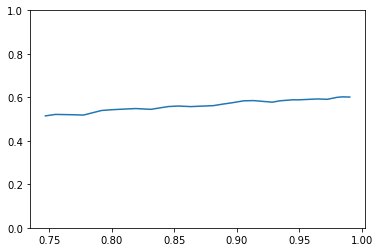

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Fill with real values
preds = out.cpu().detach().numpy()
true_labels = lab.cpu().detach().numpy()
print(sum(true_labels))
print(len(true_labels))


confidence = 0.5 + abs(preds - 0.5)

def mean(x):
    return sum(x) / len(x)

coverages = []
calculated_metrics = []

for confidence_treshold in np.arange(0.5, 1.00000000, 0.01):
    predicted_labels = 1.0 * (preds > 0.5)
    
    replace_mask = confidence < confidence_treshold
    predicted_labels[replace_mask] = 0

    coverage = mean(1.0 * (confidence > confidence_treshold))

    if len(true_labels[replace_mask]) == 0 or sum(predicted_labels) == 0:
        continue

    auc = metrics.roc_auc_score(true_labels[~replace_mask], predicted_labels[~replace_mask])
    
    calculated_metrics.append(auc)
    coverages.append(coverage)
    
plt.plot(coverages, calculated_metrics)
plt.ylim(0, 1) 
plt.show()

In [21]:
print(coverages)

[]
